# Идентификация интернет-пользователей

Финальный проект специализации МФТИ и Яндекса "Машинное обучение и анализ данных"

## Описание проекта

В этом проекте мы будем решать задачу идентификации пользователя по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Этот пилотный проект описан в статье на Хабрахабре. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".

### Подготовка данных к анализу и построению моделей

#### * Подготовка обучающей выборки

In [10]:
%load_ext watermark

In [11]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,scikit-learn -g

CPython 2.7.15
IPython 5.4.1

numpy 1.13.3
scipy 1.0.0
pandas 0.22.0
matplotlib 2.2.2
statsmodels 0.8.0
scikit-learn 0.19.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   :


/Users/yaroina-kente/src/watermark/watermark/watermark.py:155: DeprecationWarning: Importing scikit-learn as `scikit-learn` has been depracated and will not be supported anymore in v1.7.0. Please use the package name `sklearn` instead.
  DeprecationWarning)


In [265]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import numpy as np
import pandas as pd
import itertools
import pickle
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
import datetime
#import vowpal_wabbit as vw

from scipy import stats as sts
from statsmodels.stats.proportion import proportion_confint
from itertools import combinations
from time import time
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import learning_curve
from scipy.sparse import csr_matrix, hstack
from xgboost import XGBClassifier
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from scipy import sparse

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [266]:
from time import time
dict_add_time = 0;
def add_elem_to_dict(dictionary, element, filecount):
    global dict_add_time
    s_time = time()
    if element in dictionary:
        return filecount
    else:
        dictionary[element] = [filecount+1, 0]
        return filecount+1
    dict_add_time += time() - s_time
def add_freq_to_dict(dictionary, data):
    global dict_add_time
    s_time = time()
    for key in dictionary:
        a = dictionary[key][0]
        dictionary[key] = (a, data[a])
    dict_add_time += time() - s_time

Реализуем функцию prepare_train_set, которая принимает на вход путь к каталогу с csv-файлами и параметр session_length – длину сессии, а возвращает 2 объекта:
* DataFrame, в котором строки соответствуют уникальным сессиям из session_length сайтов (используйте drop_duplicates, чтоб оставить только уникальные сессии), session_length столбцов – индексам этих session_length сайтов и последний столбец – ID пользователя.
* частотный словарь сайтов вида {'site_string': [site_id, site_freq]}.

In [53]:
def prepare_train_set(csv_files_mask, session_length=10):
    # Получаем список файлов, удовлетворяющих заданной маске
    site_dict = {}
    list_of_files = glob(csv_files_mask)
    data = []

    file_counter = 0
    for path in list_of_files:
        all_sites_from_file = []
        # Читаем файлы из списка
        with open(path, 'r') as filep:
            lines = filep.readlines()[1:]
            list_of_sites = []
            for line in lines:
                # Читаем строки из файла, каждую строку разбиваем на части
                list_of_tokens = line.strip().split(',')
                # Проверяем, что строка не пуста
                if len(list_of_tokens) != 2:
                    break
                # Добавляем элемент в словарь
                file_counter = add_elem_to_dict(site_dict, list_of_tokens[1], file_counter)
                all_sites_from_file.append(site_dict[list_of_tokens[1]][0])
            user_id = int(path[-8:-4])
        n = len(all_sites_from_file)
            
        ind = 0
        while True:
            if ind + 10 > n-1:
                data.append(all_sites_from_file[ind:n] + [0 for _ in range(10 - n + ind)] + [user_id])
                break
            data.append(all_sites_from_file[ind:ind+10] + [user_id])
            ind += 10
    df = pd.DataFrame(data,columns = ['site'+str(x) for x in range(1, session_length+1)] + ['target'])
    df = df.drop_duplicates()
    add_freq_to_dict(site_dict, np.unique(df.drop(['target'], axis = 1).values.ravel(), return_counts=True)[1])
    return df, site_dict

Применим полученную функцию к данным по 10 и 150 пользователями и сохраним полученные DataFrame в csv-файлы для дальнейшего

In [55]:
t_start = time()
dict_add_time = 0;
train_data_10users, site_freq_10users = prepare_train_set('/Users/yaroina-kente/Identification/capstone_websites_data/10users/*', 
                      session_length=10)
print("Time elapsed: " + str(time()- t_start))
print(dict_add_time)
print(time()- t_start - dict_add_time)

Time elapsed: 0.439872026443
0.00462293624878
0.435939073563


In [56]:
train_data_10users.shape[0]

13265

In [57]:
dict_add_time = 0;
t_start = time()
train_data_150users, site_freq_150users = \
    prepare_train_set('capstone_websites_data/150users/*', 
                      session_length=10)
print("Time elapsed: " + str(time() - t_start))
print(time()- t_start - dict_add_time)

Time elapsed: 4.80065393448
4.76978492737


In [58]:
train_data_10users.to_csv('capstone_websites_data/train_data_10users.csv', 
                        index_label='session_id', float_format='%d')
train_data_150users.to_csv('capstone_websites_data/train_data_150users.csv', 
                         index_label='session_id', float_format='%d')

#### * Работа с разреженным форматом данных

Создадим новые матрицы, в которых строкам будут соответствовать сессии из 10 сайтов, а столбцам – индексы сайтов. На пересечении строки $i$ и столбца $j$ будет стоять число $n_{ij}$ – cколько раз сайт $j$ встретился в сессии номер $i$. Делать это будем с помощью разреженных матриц Scipy – [csr_matrix](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.html).

In [59]:
def make_sparse_data(data):
    indptr = [0]
    indices = []
    sparse_data = []
    for row in data:
        val, cnt = np.unique(row[row != 0], return_counts=True)
        indptr.append(indptr[-1] + len(val))
        for v, c in zip(val, cnt):
            indices.append(v - 1)
            sparse_data.append(c)
    return np.uint64(sparse_data),  np.uint64(indices), np.uint64(indptr)

In [60]:
X_10users, y_10users = train_data_10users.iloc[:, :-1].values, \
                       train_data_10users.iloc[:, -1].values
X_150users, y_150users = train_data_150users.iloc[:, :-1].values, \
                         train_data_150users.iloc[:, -1].values

In [61]:
t_start = time()
X_sparse_150users = csr_matrix(make_sparse_data(X_150users))  
print("Time elapsed: %lf" % (time() - t_start))

Time elapsed: 5.443839


In [62]:
X_sparse_10users = csr_matrix(make_sparse_data(X_10users))  
X_sparse_150users = csr_matrix(make_sparse_data(X_150users)) 

Сохраним эти разреженные матрицы с помощью pickle (сериализация в Python), также сохраним вектора y_10users, y_150users – целевые значения (id пользователя) в выборках из 10 и 150 пользователей. Наконец, сохраним также и частотные словари сайтов для 10 и 150 пользователей.

In [63]:
with open('capstone_websites_data/X_sparse_10users.pkl', 'wb') as X10_pkl:
    pickle.dump(X_sparse_10users, X10_pkl)
with open('capstone_websites_data/y_10users.pkl', 'wb') as y10_pkl:
    pickle.dump(y_10users, y10_pkl)
with open('capstone_websites_data/X_sparse_150users.pkl', 'wb') as X150_pkl:
    pickle.dump(X_sparse_150users, X150_pkl)
with open('capstone_websites_data/y_150users.pkl', 'wb') as y150_pkl:
    pickle.dump(y_150users, y150_pkl)
with open('capstone_websites_data/site_freq_10users.pkl', 'wb') as site_freq_10users_pkl:
    pickle.dump(site_freq_10users, site_freq_10users_pkl)
with open('capstone_websites_data/site_freq_150users.pkl', 'wb') as site_freq_150users_pkl:
    pickle.dump(site_freq_150users, site_freq_150users_pkl)

### Подготовка и первичный анализ данных

#### * Подготовка нескольких обучающих выборок для сравнения

Реализуем функцию *prepare_sparse_train_set_window, которая возвращает 2 объекта:
* разреженную матрицу *X_sparse* (двухмерная Scipy.sparse.csr_matrix), в которой строки соответствуют сессиям из *session_length* сайтов, а *max(site_id)* столбцов – количеству посещений *site_id* в сессии. 
* вектор *y* (Numpy array) "ответов" в виде ID пользователей, которым принадлежат сессии из *X_sparse*.

In [94]:
def prepare_train_set_window(csv_files_mask, site_freq_path, session_length=5, window_width = 3):
    # Получаем список файлов, удовлетворяющих заданной маске
    list_of_files = glob(csv_files_mask)
    data = []
    
    with open(site_freq_path, "rb") as fp:
        site_dict = pickle.load(fp)
              
    for path in list_of_files:
        all_sites_from_file = []
        # Читаем файлы из списка
        with open(path, 'r') as filep:
            lines = filep.readlines()[1:]
            list_of_sites = []
            for line in lines:
                # Читаем строки из файла, каждую строку разбиваем на части
                list_of_tokens = line.strip().split(',')
                # Проверяем, что строка не пустая
                if len(list_of_tokens) != 2:
                    break
                # Добавляем элемент в словарь
                all_sites_from_file.append(site_dict[list_of_tokens[1]][0])
                user_id = int(path[-8:-4])
        n = len(all_sites_from_file)
        ind = 0
        while True:
            if ind + session_length > n-1:
                data.append(all_sites_from_file[ind:n] + [0 for _ in range(session_length - n + ind)] + [user_id])
            else:
                data.append(all_sites_from_file[ind:ind+session_length] + [user_id])
            ind += window_width
            if ind >= n:
                break
    df = pd.DataFrame(data,columns = ['site'+str(x) for x in range(1, session_length+1)] + ['target'])
    return df.drop_duplicates()

In [68]:
def make_sparse_data(data):
    indptr = [0]
    indices = []
    sparse_data = []
    for row in data:
        sites, visits = np.unique(row[row != 0], return_counts=True)
        indptr.append(indptr[-1] + len(sites))
        for v, c in zip(sites, visits):
            indices.append(v - 1)
            sparse_data.append(c)
    return np.uint64(sparse_data),  np.uint64(indices), np.uint64(indptr)

In [69]:
def prepare_sparse_train_set_window(csv_files_mask, site_freq_path, session_length=10, window_size=10):
    
    data = prepare_train_set_window(csv_files_mask, 
                                    site_freq_path, 
                                    session_length=session_length, 
                                    window_width = window_size)
    X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
    X_sparse = csr_matrix(make_sparse_data(X)) 
    return X_sparse, y

Запустим созданную функцию 16 раз с помощью циклов по числу пользователей num_users (10 или 150), значениям параметра *session_length* (15, 10, 7 или 5) и значениям параметра *window_size* (10, 7 или 5).

In [71]:
%%time
data_lengths = []

for num_users in [10, 150]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length and (window_size, session_length) != (10, 10):
            X_sparse, y = prepare_sparse_train_set_window('capstone_websites_data/%dusers/*' % num_users, 
                                                          'capstone_websites_data/site_freq_%dusers.pkl' % num_users,
                                                           session_length=session_length, 
                                                           window_size=window_size)
            data_lengths.append(X_sparse.shape[0])
            file_name = 'capstone_websites_data/X_sparse_%dusers_s%d_w%d.pkl' % (num_users, session_length, window_size) 
            with open(file_name, 'wb') as fp:
                pickle.dump(X_sparse, fp)
            file_name = 'capstone_websites_data/y_%dusers_s%d_w%d.pkl' % (num_users, session_length, window_size)
            with open(file_name,'wb') as fp:
                pickle.dump(y, fp)

CPU times: user 2min 35s, sys: 6.15 s, total: 2min 41s
Wall time: 2min 45s


#### * Первичный анализ данных, проверка гипотез

Считаем в DataFrame файл train_data_10users.csv. Посмотрим распределние целевого класса и посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.

In [72]:
train_df = pd.read_csv('capstone_websites_data/train_data_10users.csv', 
                       index_col='session_id')

In [73]:
train_df['target'].value_counts()

128    2435
39     1997
207    1865
127    1662
237    1619
33     1004
31      752
50      751
100     658
241     522
Name: target, dtype: int64

In [74]:
num_unique_sites = [np.unique(train_df.values[i, :-1]).shape[0] 
                    for i in range(train_df.shape[0])]

In [75]:
pd.Series(num_unique_sites).value_counts()

7     2306
6     2197
8     2046
5     1735
9     1394
4     1163
3      892
2      821
10     651
1       60
dtype: int64

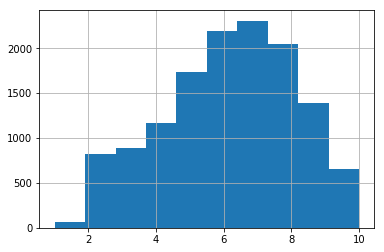

In [76]:
pd.Series(num_unique_sites).hist();

С помощью QQ-плота и критерия Шапиро-Уилка проверим, что эта величина распределена нормально.

((array([-3.87988713, -3.65852792, -3.53717169, ...,  3.53717169,
          3.65852792,  3.87988713]), array([ 1,  1,  1, ..., 10, 10, 10])),
 (2.116485975246492, 6.2158311345646426, 0.97961557502565588))

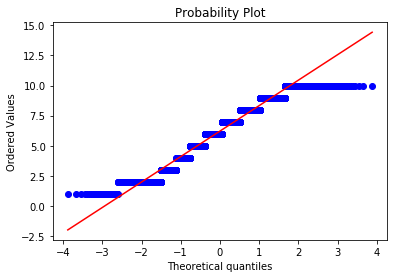

In [77]:
fig, ax = plt.subplots()
sts.probplot(num_unique_sites, plot=ax)

In [78]:
W, p_val = sts.shapiro(num_unique_sites)
print("p-value for Shapiro-Wilk test: %lf" % p_val)

p-value for Shapiro-Wilk test: 0.000000


Нет, число уникальных сайтов в сессии не распределено нормально.

Проверим гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов.

In [79]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')
sts.binom_test(has_two_similar.sum(), has_two_similar.shape[0], p=0.95)/2

0.32341251891634082

Построим распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для сайтов, которые были посещены как минимум 1000 раз.

In [80]:
with open('capstone_websites_data/site_freq_10users.pkl', "r") as fp:
        site_dict = pickle.load(fp)
key_to_delete = []
for key in site_dict:
    freq = site_dict[key][1]
    if freq < 1000:
        key_to_delete.append(key)
    else:
        site_dict[key] = site_dict[key][1]
for key in key_to_delete:
    site_dict.pop(key, None)
site_dict

{'accounts.google.com': 2087,
 'accounts.youtube.com': 1055,
 'apis.google.com': 3756,
 'clients1.google.com': 1493,
 'clients6.google.com': 1039,
 'fr-mg42.mail.yahoo.com': 1716,
 'i1.ytimg.com': 1232,
 'mail.google.com': 4093,
 'platform.twitter.com': 1041,
 'plus.google.com': 2611,
 'r1---sn-gxo5uxg-jqbe.googlevideo.com': 2187,
 'r2---sn-gxo5uxg-jqbe.googlevideo.com': 1720,
 'r3---sn-gxo5uxg-jqbe.googlevideo.com': 2010,
 'r4---sn-gxo5uxg-jqbe.googlevideo.com': 1574,
 's-static.ak.facebook.com': 1388,
 's.youtube.com': 6532,
 'safebrowsing-cache.google.com': 1029,
 'static.ak.facebook.com': 1265,
 'twitter.com': 1204,
 'www.facebook.com': 4081,
 'www.google.com': 5068,
 'www.google.fr': 7809,
 'www.youtube.com': 1804}

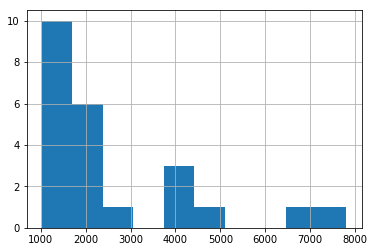

In [81]:
site_freqs = site_dict.values()
pd.Series(site_freqs).hist();

### Визуальный анализ данных построение признаков

#### * Построение признаков

Создадим на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие 13 признаков:**
* time_diff1, ..., time_diff9 – промежутки между посещением 1 и 2 сайта, ..., 9 и 10 сайта в сессии (в секундах). Посещения сайтов не сторого упорядочены по времени, поэтому эти величины где-то могут быть отрицательными. Если сайтов в сессии меньше 10, разницы можно сделать нулевыми
* session_timespan – продолжительность сессии. Из-за того, что посещения сайтов не сторого упорядочены по времени, продолжительностью сессии будем считать разницу между максимальным и минимальным временем посещения сайтов в сессии (в секундах).
* #unique_sites – число уникальных сайтов в сессии 
* start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)
* day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти).

Порядок, в котором добавляются признаки: *site1*, ... *site10*, *time_diff1*, ..., *time_diff9*, *session_timespan*, *#unique_sites*, *start_hour*,*day_of_week*,*target* (это видно и чуть ниже по тому, как функция вызывается).

In [82]:
def diff_for_date(a):
    if a.size < 2:
        return []
    else:
        return map(int, map(datetime.timedelta.total_seconds, np.diff(a).tolist()))

In [87]:
def prepare_train_set_with_fe(csv_files_mask, site_freq_path, feature_names, session_length=10, window_width=10):
    
    # Получаем список файлов, удовлетворяющих заданной маске
    list_of_files = glob(csv_files_mask)
    data = []
    
    # Feature engineering
    time_diff_list = []
    min_time = 0
    max_time = 0
    unique_sites = {}
    
    # Reading site dictionary
    with open(site_freq_path, "rb") as fp:
        site_dict = pickle.load(fp)
        
    # Reading data files
    for path in list_of_files:
        all_sites_from_file = []
        all_times_from_file = []
        # Читаем файлы из списка
        with open(path, 'r') as filep:
            lines = filep.readlines()[1:]
            list_of_sites = []
            for line in lines:
                # Читаем строки из файла, каждую строку разбиваем на части
                list_of_tokens = line.strip().split(',')
                # Проверяем, что строка не пустая
                if len(list_of_tokens) != 2:
                    break
                # Добавляем элемент в словарь
                all_sites_from_file.append(site_dict[list_of_tokens[1]][0])
                all_times_from_file.append(list_of_tokens[0])
                user_id = int(path[-8:-4])
        n = len(all_sites_from_file)
        
        ind = 0
        while True:
            if ind + session_length > n-1:
                a = np.array(all_times_from_file[ind:n], dtype='datetime64')
                sites = all_sites_from_file[ind:ind+session_length]
                time_diff = diff_for_date(a) + [0 for _ in range(session_length - n + ind)]
                min_time = a.min()
                data.append(sites + [0 for _ in range(session_length - n + ind)] + 
                            time_diff +
                            [int((a.max() - min_time).tolist().total_seconds())] +
                            [len(set(sites))] +
                            [min_time.tolist().hour] + 
                            [min_time.tolist().weekday()] +
                            [user_id])
            else:
                a = np.array(all_times_from_file[ind:ind+session_length], dtype='datetime64')
                sites = all_sites_from_file[ind:ind+session_length]
                time_diff = diff_for_date(a)
                min_time = a.min()
                data.append(sites + 
                            time_diff + 
                            [int((a.max() - min_time).tolist().total_seconds())] +
                            [len(set(sites))] + 
                            [min_time.tolist().hour] + 
                            [min_time.tolist().weekday()] +
                            [user_id])
            ind += window_width
            if ind >= n:
                break
    df = pd.DataFrame(data,columns = feature_names)
    return df.drop_duplicates()

Применим функцию *prepare_train_set_with_fe* к данным по 10 и 150 пользователям, укажите session_length=10.

In [88]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']

In [89]:
t_start = time()
train_data_10users = prepare_train_set_with_fe('capstone_websites_data/10users/*', 
                                               site_freq_path='capstone_websites_data/site_freq_10users.pkl',
                                               feature_names=feature_names, session_length=10)
print("Time elapsed", time() - t_start)

Time elapsed 1.43542909622


In [90]:
t_start = time()
train_data_150users = prepare_train_set_with_fe('capstone_websites_data/150users/*', 
                                               site_freq_path='capstone_websites_data/site_freq_150users.pkl',
                                               feature_names=feature_names, session_length=10)
print("Time elapsed", time() - t_start)

Time elapsed 12.3295738697


Сохраним в pickle-файлы *time_diff1*,..., *time_diff9, session_timespan, #unique_sites, start_hour* и *day_of_week* для 10 и 150 пользователей.

In [91]:
new_features = ['time_diff' + str(j) for j in range(1,10)] + \
               ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']

In [92]:
new_features_10users = train_data_10users[new_features]
new_features_150users = train_data_150users[new_features]

In [95]:
with open('capstone_websites_data/new_features_10users.pkl', 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open('capstone_websites_data/new_features_150users.pkl', 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

#### * Визуальный анализ данных

Дадим пользователям имена и ассоциируем с ними цвета.

In [96]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [97]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

Построим гистограмму распределения длины сессии в секундах (*session_timespan*).

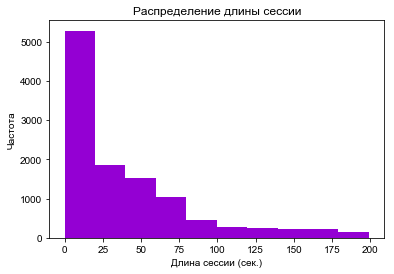

In [98]:
matplotlib.rc('font', family='Arial')
fig, ax = plt.subplots()
train_data_10users[train_data_10users.session_timespan < 200]['session_timespan'].plot(kind='hist', color='darkviolet', ax=ax)
ax.set_xlabel(u'Длина сессии (сек.)')
ax.set_ylabel(u'Частота')
ax.set_title(u'Распределение длины сессии');

Построим гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*).

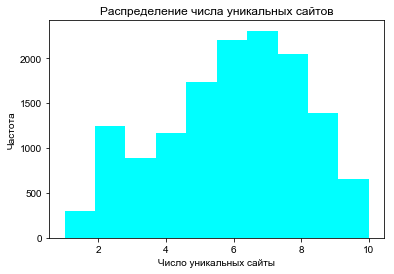

In [99]:
fig, ax = plt.subplots()
train_data_10users['#unique_sites'].plot(kind='hist', ax=ax, color='aqua')
ax.set_xlabel(u'Число уникальных сайты')
ax.set_ylabel(u'Частота')
ax.set_title(u'Распределение числа уникальных сайтов');

Построим гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности.

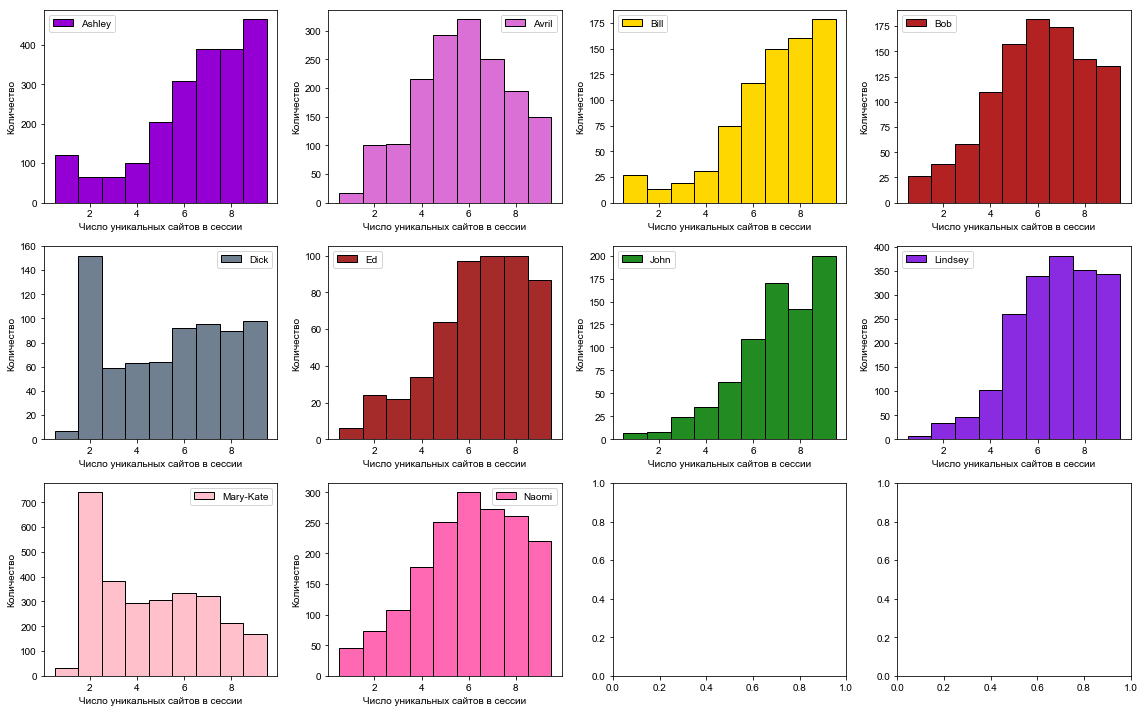

In [101]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')):
    i, j = idx // 4, idx % 4
    num_unique_sites_hist = sub_df['#unique_sites']
    bins = range(num_unique_sites_hist.min(), int(np.ceil(num_unique_sites_hist.max())) + 1)
    ax[i, j].hist(num_unique_sites_hist, label=user, color=color_dic[user], edgecolor='black', bins=bins, align='left')
    ax[i, j].legend()
    ax[i, j].set_xlabel(u'Число уникальных сайтов в сессии')
    ax[i, j].set_ylabel(u'Количество')
    plt.tight_layout()

Построим гистограмму распределения часа начала сессии (*start_hour*).

Text(0.5,1,u'\u0420\u0430\u0441\u043f\u0440\u0435\u0434\u0435\u043b\u0435\u043d\u0438\u0435 \u0447\u0430\u0441\u0430 \u043d\u0430\u0447\u0430\u043b\u0430 \u0441\u0435\u0441\u0438\u0438')

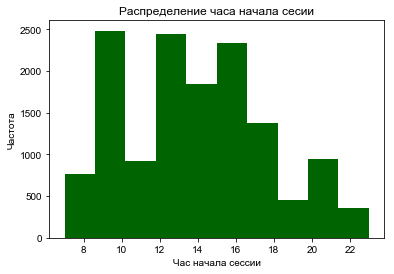

In [102]:
fig, ax = plt.subplots()
train_data_10users['start_hour'].plot(kind='hist', color='darkgreen', ax=ax)
ax.set_xlabel(u'Час начала сессии')
ax.set_ylabel(u'Частота')
ax.set_title(u'Распределение часа начала сесии')

Построим гистограммы распределения часа начала сессии (start_hour) для каждого из 10 пользователей по отдельности.

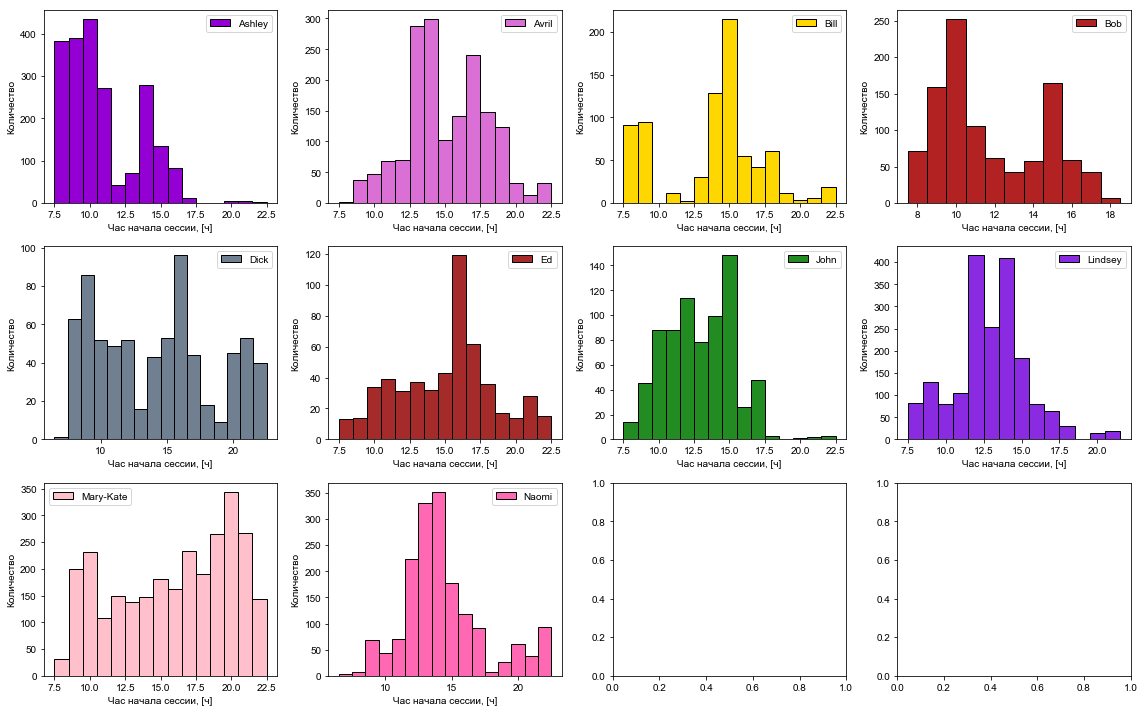

In [104]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')):
    i, j = idx // 4, idx % 4
    start_hour_hist = sub_df['start_hour']
    bins = range(start_hour_hist.min(), int(np.ceil(start_hour_hist.max())) + 1)
    ax[i, j].hist(start_hour_hist, label=user, color=color_dic[user], edgecolor='black', bins=bins, align='left')
    ax[i, j].legend()
    ax[i, j].set_xlabel(u'Час начала сессии, [ч]')
    ax[i, j].set_ylabel(u'Количество')
    plt.tight_layout()

Построим гистограмму распределения дня недели, в который началась сессия (*day_of_week*).

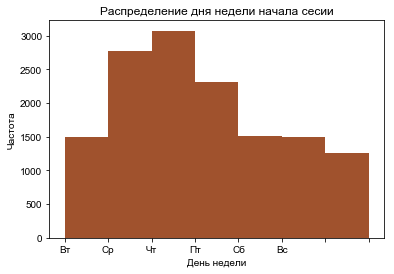

In [105]:
fig, ax = plt.subplots()
train_data_10users['day_of_week'].plot(kind='hist', ax=ax, color='sienna', bins=range(8))
ax.set_xlabel(u'День недели')
ax.set_ylabel(u'Частота')
ax.set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб',  u'Вс'])
ax.set_title(u'Распределение дня недели начала сесии');

Построим гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности.

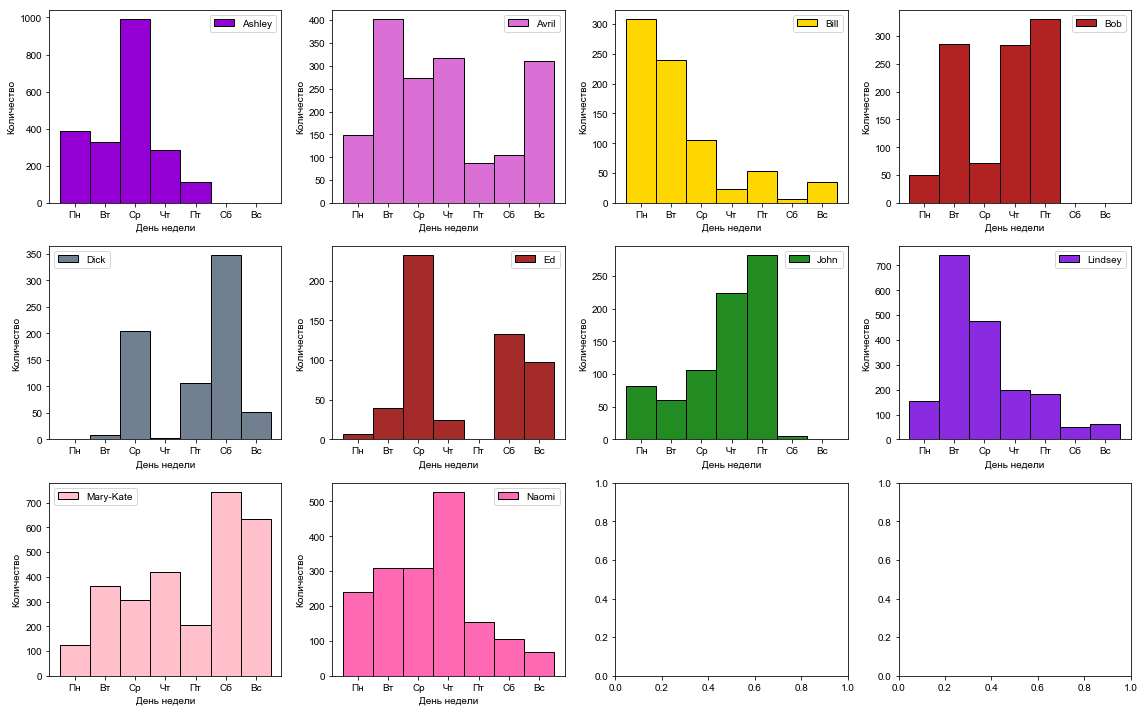

In [106]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')):
    i, j = idx // 4, idx % 4
    day_of_week_hist = sub_df['day_of_week']
    bins = range(0, 8)
    ax[i, j].hist(day_of_week_hist, label=user, color=color_dic[user], edgecolor='black', bins=bins, align='left')
    ax[i, j].legend()
    ax[i, j].set_xlabel(u'День недели')
    ax[i, j].set_ylabel(u'Количество')
    plt.tight_layout()
    ax[i, j].set_xticks(range(0, 7))
    ax[i, j].set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])

Выводы по каждому из пользователей:

* Ashley: 8-9 уникальных сайтов за сессию; утром и в обед; только в будние дни (в среду пик активности)
* Avril: 6 уникальных сайтов за сессию; в обед и сразу после работы; пик активности середина рабочей недели и вс
* Bill: 8-9 уникальных сайтов за сессию;  утром и в обед; пик активности приходится на начало рабочей недели
* Lindsey: 7-8 уникальных сайтов за сессию; в течении рабочего дня с пиком в обед; пик в вт-ср
* Dick: равномерно, кроме пн и вт; утром, днём и вечером; выходные и середина недели
* Ed: 7-8 уникальных сайтов за сессию; равномерно, пик после обеда; выходные и середина недели
* John: 6-7 уникальных сайтов за сессию; в течение рабочего дня; в основном будние дни с увеличением к пятнице
* Mary-Kate: равномерно, кроме пн и вт; равномерно; чаще в выходные
* Naomi: 6-7 уникальных сайтов за сессию; в обед и поздний вечер; чаще в рабочие дни
* Bob: 6-7 уникальных сайтов за сессию; утром и в обед; только в будние дни

Загрузим сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. Определим топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).

In [107]:
with open("capstone_websites_data/site_freq_10users.pkl") as fid:
    site_freq_10 = pickle.load(fid)

In [108]:
def itemgetter_own(*items):
    if len(items) == 1:
        item = items[0]
        def g(obj):
            return obj[item][1]
    return g

In [109]:
top10_popular = sorted(site_freq_10.items(), key=itemgetter_own(1), reverse=True)[:10]
top10_popular

[('www.google.fr', (51, 7809)),
 ('s.youtube.com', (210, 6532)),
 ('www.google.com', (4, 5068)),
 ('mail.google.com', (183, 4093)),
 ('www.facebook.com', (15, 4081)),
 ('apis.google.com', (52, 3756)),
 ('plus.google.com', (187, 2611)),
 ('r1---sn-gxo5uxg-jqbe.googlevideo.com', (214, 2187)),
 ('accounts.google.com', (184, 2087)),
 ('r3---sn-gxo5uxg-jqbe.googlevideo.com', (700, 2010))]

In [110]:
top10_freqs = [freq for _, (ind, freq) in top10_popular]
top10_sites = [site for site, _ in top10_popular]

In [111]:
print(zip(top10_sites, top10_freqs))

[('www.google.fr', 7809), ('s.youtube.com', 6532), ('www.google.com', 5068), ('mail.google.com', 4093), ('www.facebook.com', 4081), ('apis.google.com', 3756), ('plus.google.com', 2611), ('r1---sn-gxo5uxg-jqbe.googlevideo.com', 2187), ('accounts.google.com', 2087), ('r3---sn-gxo5uxg-jqbe.googlevideo.com', 2010)]


Нарисуем seaborn barplot, показывающий частоты посещений топ-10 сайтов.

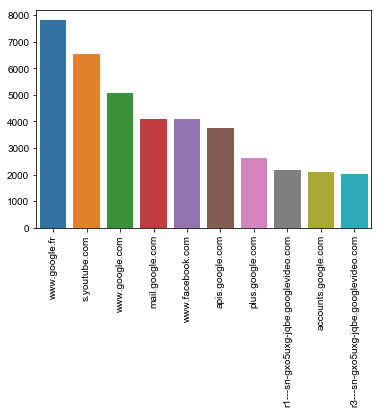

In [122]:
ax = sns.barplot(top10_sites, top10_freqs)
ax.set_xticklabels(top10_sites, rotation=90);

#### * Дальнейшее построение признаков

Напишем функцию для создания новых признаков (время суток, среднее время пребывания на сайте, частота посещения Facebook и прочие) и применим ее к исходным данным – каталогам с 10 и 150 файлами.

In [117]:
def feature_engineering(df_data):
    df_new_data = df_data.copy()
    df_new_data['log_session_timespan'] = df_new_data['session_timespan'].apply(lambda x: np.log(x + 1))
    df_new_data['log_sess_ts_avg'] = df_new_data['log_session_timespan']/df_new_data['#unique_sites']
    df_new_data['ind_morning'] = df_new_data['start_hour'].apply(lambda x: int(6 <= x and x < 12))
    df_new_data['ind_afternoon'] = df_new_data['start_hour'].apply(lambda x: int(12 <= x and x < 18))
    df_new_data['ind_evening'] = df_new_data['start_hour'].apply(lambda x: int(18 <= x and x < 24))
    df_new_data['ind_weekend'] = df_new_data['day_of_week'].apply(lambda x: int(x >= 5))
    time_diff_list = ['time_diff' + str(i) for i in range(1,10)]
    df_new_data['low_time_diff'] = (df_new_data[time_diff_list].apply(np.abs) < 2).sum(axis = 1)
    new_features_list = ['log_session_timespan', 'log_sess_ts_avg', 'ind_morning',
                        'ind_afternoon', 'ind_evening', 'ind_weekend', 'low_time_diff']
    for (i, j) in combinations(['site' + str(i) for i in range(1, 11)], 2):
        df_new_data[i + "#" + j] = df_new_data[i].apply(str) + "#" + df_new_data[j].apply(str)
        new_features_list.append(i + "#" + j)
    return df_new_data[new_features_list]

In [118]:
new_features_10users = feature_engineering(train_data_10users)
new_features_150users = feature_engineering(train_data_150users)

Проверим новые признаки на информативмость.

Text(0,0.5,u'\u0427\u0430\u0441\u0442\u043e\u0442\u0430')

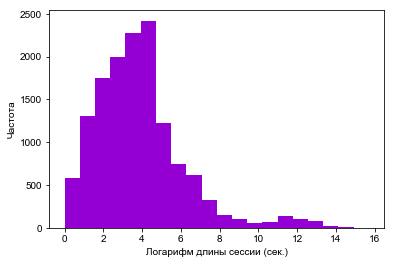

In [119]:
fig, ax = plt.subplots()
new_features_10users['log_session_timespan'].plot(kind='hist', color='darkviolet', ax=ax, bins = 20)
ax.set_xlabel(u'Логарифм длины сессии (сек.)')
ax.set_ylabel(u'Частота')

In [120]:
features_with_target = pd.concat([new_features_10users, train_data_10users['target']], axis=1)

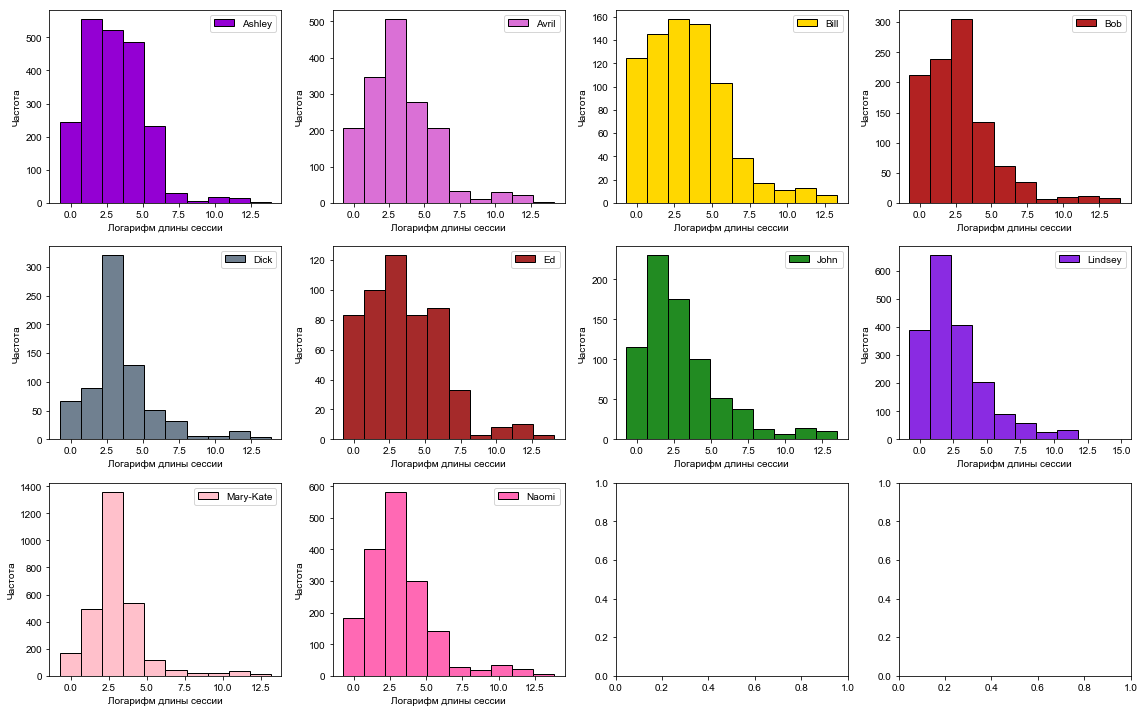

In [123]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(features_with_target.groupby('target')):
    i, j = idx // 4, idx % 4
    start_hist = sub_df['log_session_timespan']
    bins = 10
    axes[i, j].hist(start_hist, label=user, color=color_dic[user], edgecolor='black', bins=bins, align='left')
    axes[i, j].legend()
    axes[i, j].set_xlabel(u'Логарифм длины сессии')
    axes[i, j].set_ylabel(u'Частота')
    plt.tight_layout()    

По этому признаку можем выделить несколько групп пользователей: Dick, Mary-Kate, Naomi; John, Lindsey, Bob, Avril, все остальные.

Text(0,0.5,u'\u0427\u0430\u0441\u0442\u043e\u0442\u0430')

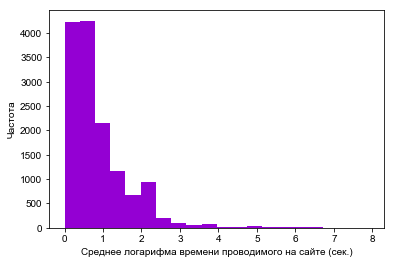

In [124]:
fig, ax = plt.subplots()
new_features_10users['log_sess_ts_avg'].plot(kind='hist', color='darkviolet', ax=ax, bins = 20)
ax.set_xlabel(u'Среднее логарифма времени проводимого на сайте (сек.)')
ax.set_ylabel(u'Частота')

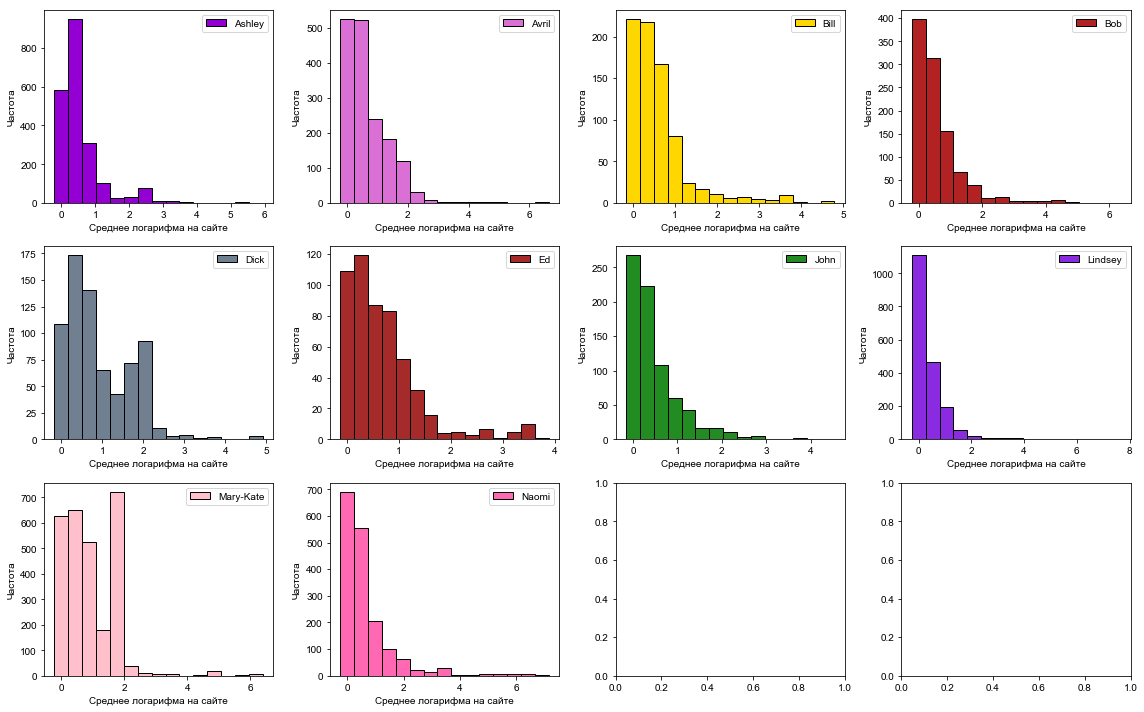

In [125]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(features_with_target.groupby('target')):
    i, j = idx // 4, idx % 4
    start_hist = sub_df['log_sess_ts_avg']
    bins = 15
    axes[i, j].hist(start_hist, label=user, color=color_dic[user], edgecolor='black', bins=bins, align='left')
    axes[i, j].legend()
    axes[i, j].set_xlabel(u'Среднее логарифма на сайте')
    axes[i, j].set_ylabel(u'Частота')
    plt.tight_layout()       

Видим, что есть различные виды распределений данного признака, т.е. его тоже можно использовать для идентификации пользователей.

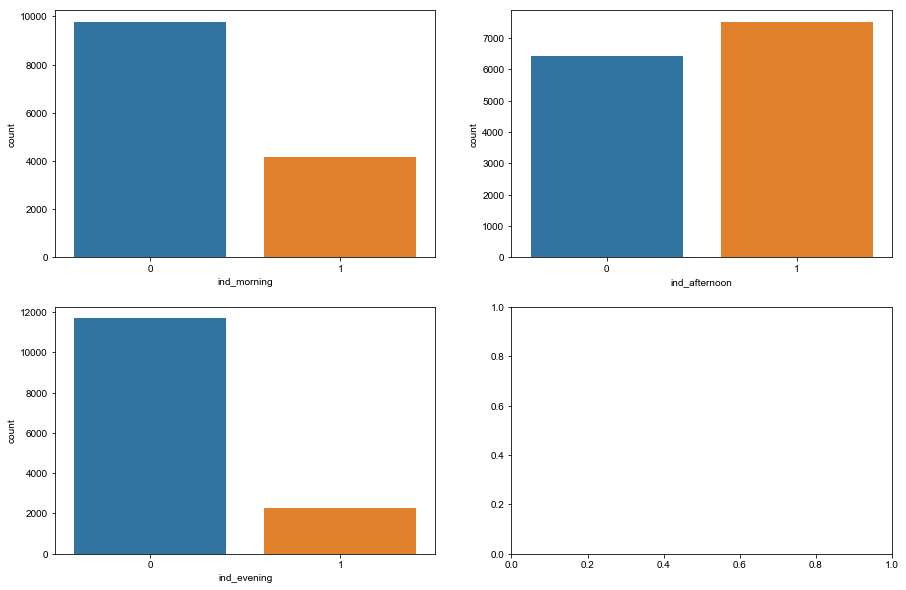

In [126]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
sns.countplot(new_features_10users['ind_morning'], ax=ax[0,0])
sns.countplot(new_features_10users['ind_afternoon'], ax=ax[0,1])
sns.countplot(new_features_10users['ind_evening'], ax=ax[1,0])

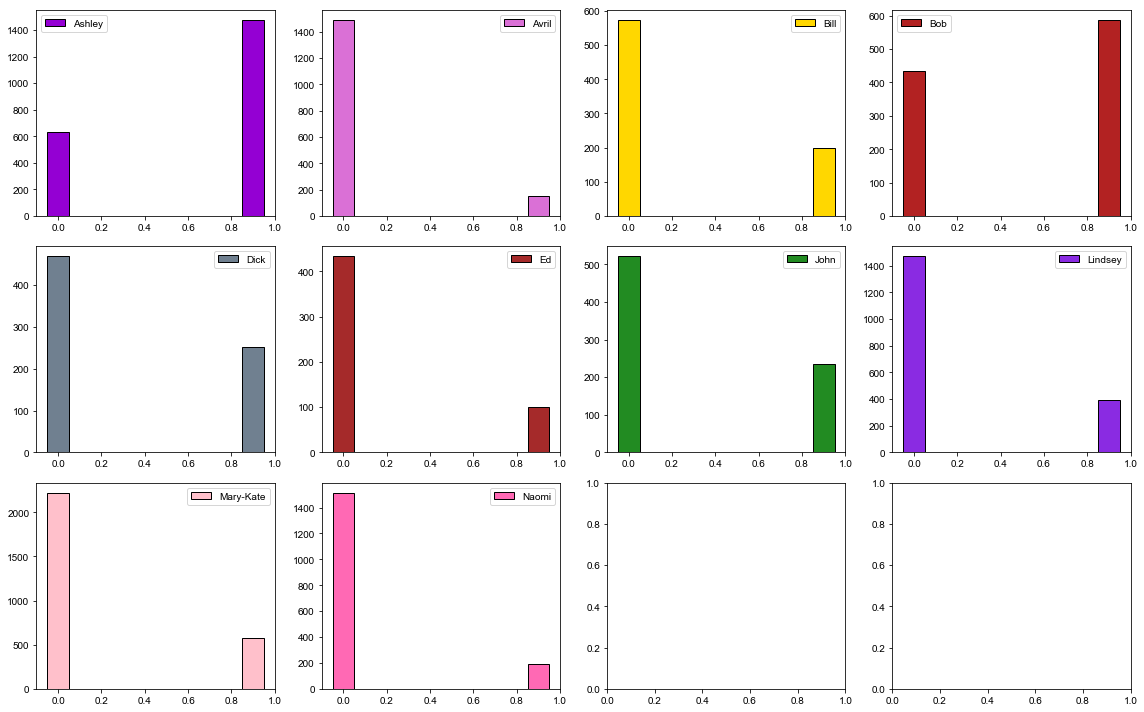

In [127]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(features_with_target.groupby('target')):
    i, j = idx // 4, idx % 4
    start_hist = sub_df['ind_morning']
    bins = 10
    axes[i, j].hist(start_hist, label=user, color=color_dic[user], edgecolor='black', bins=bins, align='left')
    axes[i, j].legend()
    plt.tight_layout()     

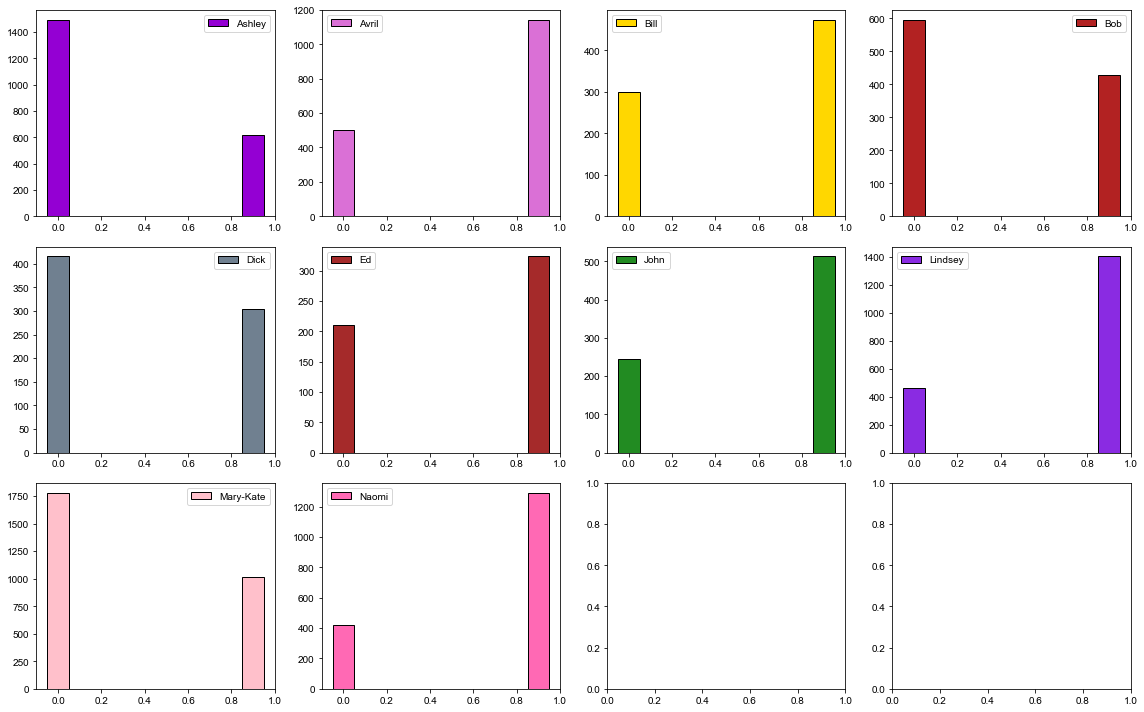

In [128]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(features_with_target.groupby('target')):
    i, j = idx // 4, idx % 4
    start_hist = sub_df['ind_afternoon']
    bins = 10
    axes[i, j].hist(start_hist, label=user, color=color_dic[user], edgecolor='black', bins=bins, align='left')
    axes[i, j].legend()
    plt.tight_layout()   

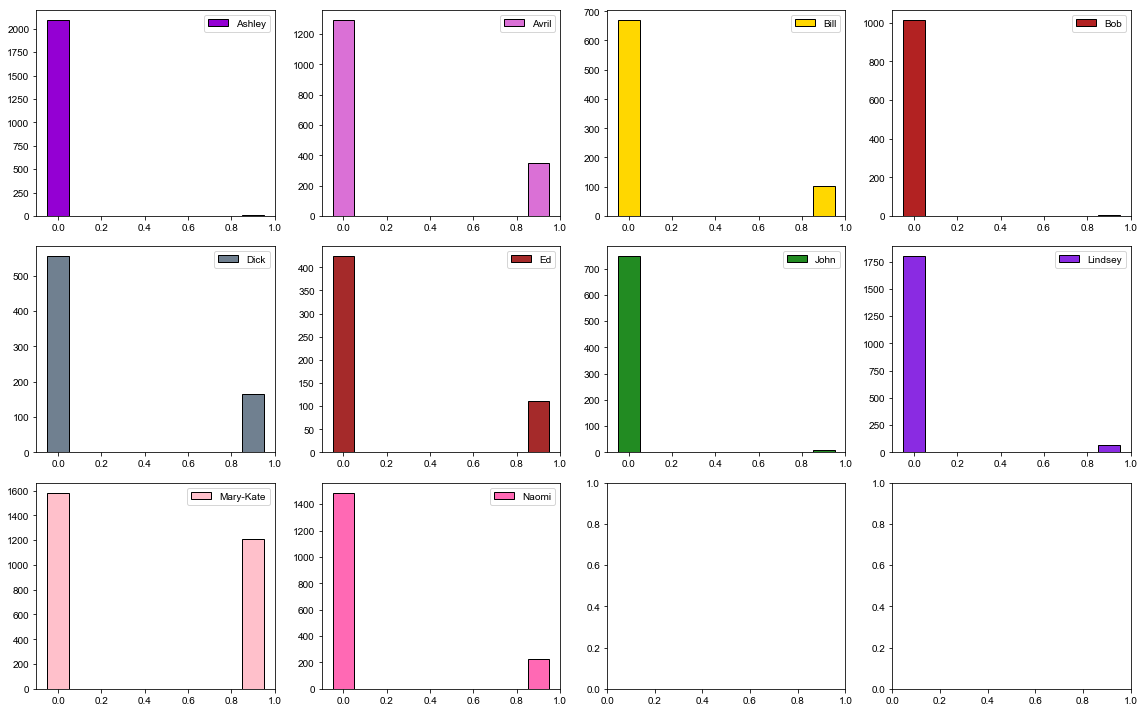

In [129]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(features_with_target.groupby('target')):
    i, j = idx // 4, idx % 4
    start_hist = sub_df['ind_evening']
    bins = 10
    axes[i, j].hist(start_hist, label=user, color=color_dic[user], edgecolor='black', bins=bins, align='left')
    axes[i, j].legend()
    plt.tight_layout() 

Все три признака позволяют различать пользователей и достаточно информативны.

Text(0,0.5,u'\u0427\u0430\u0441\u0442\u043e\u0442\u0430')

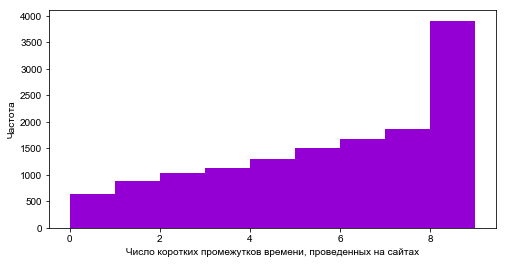

In [130]:
fig, ax = plt.subplots(figsize=(8,4))
new_features_10users['low_time_diff'].plot(kind='hist', color='darkviolet', ax=ax, bins = 9)
ax.set_xlabel(u'Число коротких промежутков времени, проведенных на сайтах')
ax.set_ylabel(u'Частота')

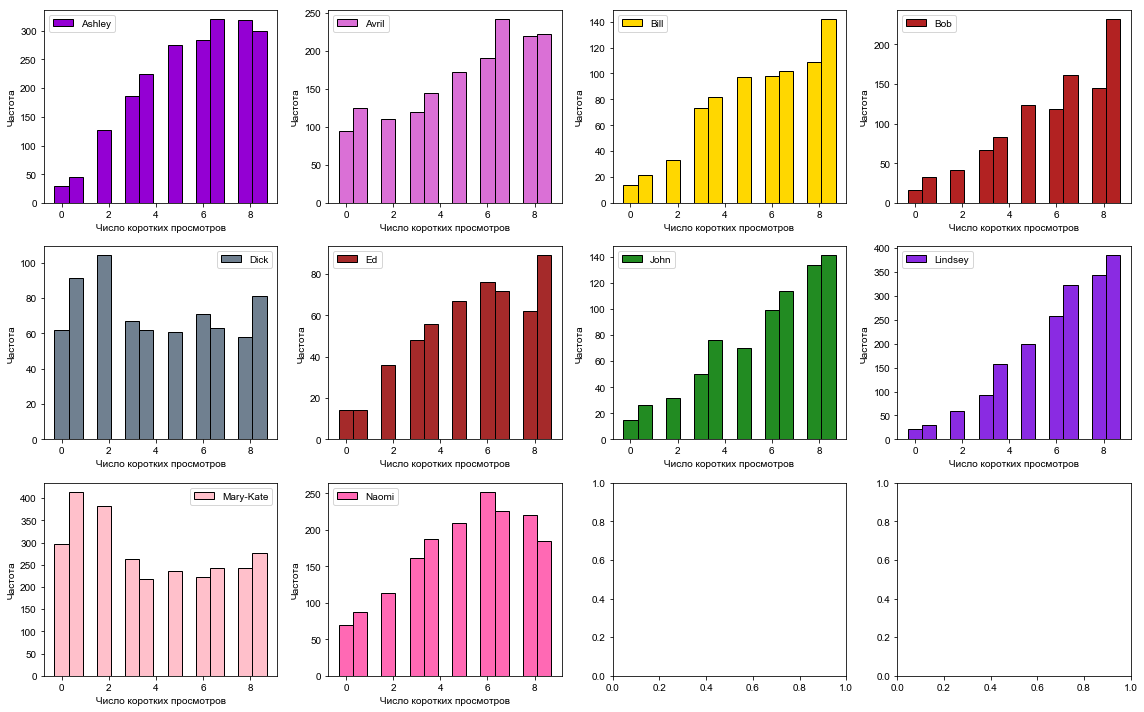

In [131]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(features_with_target.groupby('target')):
    i, j = idx // 4, idx % 4
    start_hist = sub_df['low_time_diff']
    bins = 15
    axes[i, j].hist(start_hist, label=user, color=color_dic[user], edgecolor='black', bins=bins, align='left')
    axes[i, j].legend()
    axes[i, j].set_xlabel(u'Число коротких просмотров')
    axes[i, j].set_ylabel(u'Частота')
    plt.tight_layout()   

Этот признак также является полезным в различении пользователей.

Сохраним в pickle-файлы те признаки, которые помогут идентифицировать пользователя более точно.

In [132]:
features_list = ['site' + str(i) for i in range(1, 11)] + \
                ['time_diff' + str(i) for i in range(1,10)] + ['#unique_sites', 'start_hour', 'day_of_week']

In [133]:
selected_features_10users = pd.concat([train_data_10users[features_list], new_features_10users],axis=1)
selected_features_150users=pd.concat([train_data_150users[features_list],new_features_150users],axis=1) 

In [134]:
with open('capstone_websites_data/selected_features_10users.pkl', 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl)
with open('capstone_websites_data/selected_features_150users.pkl', 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl)

### Сравнение алгоритмов классификации

#### * Сравнение нескольких алгоритмов на сессиях из 10 сайтов

Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей. Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации. Тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=7 – для воспроизводимости.

In [135]:
with open('capstone_websites_data/X_sparse_10users.pkl', 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open('capstone_websites_data/y_10users.pkl', 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

In [136]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=7, stratify=y_10users)

In [137]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).

In [138]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

Обучим KNeighborsClassifier со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только n_jobs=-1 для распараллеливания) и посмотрим на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект StratifiedKFold skf) по выборке (X_train, y_train) и отдельно на выборке (X_valid, y_valid).

In [139]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

In [140]:
%%time
knn_cv_scores = cross_val_score(knn, X_train, y_train, cv=skf, n_jobs=-1)

CPU times: user 216 ms, sys: 172 ms, total: 388 ms
Wall time: 2.15 s


In [141]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=100, p=2,
           weights='uniform')

In [142]:
%%time
knn_valid_acc = accuracy_score(y_valid, knn.predict(X_valid))
knn_valid_acc

CPU times: user 1.42 s, sys: 1.29 s, total: 2.7 s
Wall time: 3.95 s


Обучим случайный лес (RandomForestClassifier) из 100 деревьев (для воспроизводимости random_state=7). Посмотрим на OOB-оценку (oob_score=True) и на долю правильных ответов на выборке (X_valid, y_valid). Для распараллеливания n_jobs=-1.

In [143]:
forest = RandomForestClassifier(n_estimators=100, random_state=7, oob_score=True)

In [144]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=7, verbose=0, warm_start=False)

In [145]:
forest.oob_score_

0.71233171782444804

In [146]:
rf_valid_acc = accuracy_score(y_valid, forest.predict(X_valid))
rf_valid_acc

0.71909547738693469

Обучим логистическую регрессию (LogisticRegression) с параметром C по умолчанию и random_state=7 (для воспроизводимости). Посмотрим на долю правильных ответов на кросс-валидации (используйте объект skf) и на выборке (X_valid, y_valid). Для распараллеливания n_jobs=-1.

In [147]:
logit = LogisticRegression(random_state=7)

In [148]:
%%time
logit_cv_scores = cross_val_score(logit, X_train, y_train, cv=skf, n_jobs=-1)

CPU times: user 142 ms, sys: 68.8 ms, total: 210 ms
Wall time: 1.42 s


In [149]:
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=7, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [150]:
accuracy_score(y_valid, logit.predict(X_valid))

0.78492462311557787

С помощью LogisticRegressionCV подберём параметр C для LogisticRegression сначала в широком диапазоне: 10 значений от 1e-4 до 1e4. У  LogisticRegressionCV параметры multi_class='multinomial' и random_state=7. Для кросс-валидации используйте объект skf. Для распараллеливания n_jobs=-1. Нарисуем кривые валидации по параметру С.

In [153]:
%%time
logit_c_values2 = np.linspace(1e-3, 1, 30)
logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv=skf, random_state=7, n_jobs=-1, multi_class='multinomial')
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 2.66 s, sys: 389 ms, total: 3.05 s
Wall time: 58.4 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [155]:
logit_mean_cv_scores2 = logit_grid_searcher2.scores_[31].mean(axis=0)

In [156]:
print(logit_mean_cv_scores2.max(), logit_grid_searcher2.Cs_[logit_mean_cv_scores2.argmax()])

0.7598300573 1.0


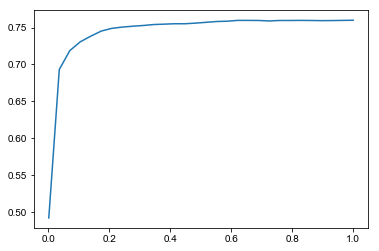

In [157]:
plot(logit_c_values2, logit_mean_cv_scores2);

Обучим линейный SVM (LinearSVC) с параметром C=1 и random_state=7 (для воспроизводимости). Посмотрим на долю правильных ответов на кросс-валидации (используйте объект skf) и на выборке (X_valid, y_valid).

In [158]:
svm = LinearSVC(C=1, random_state=7)

In [159]:
svm_cv_scores = cross_val_score(svm, X_train, y_train, cv=skf, n_jobs=-1)

In [160]:
svm.fit(X_train, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=7, tol=0.0001,
     verbose=0)

In [161]:
accuracy_score(y_valid, svm.predict(X_valid))

0.77336683417085428

С помощью GridSearchCV подберём параметр C для SVM в диапазоне (1e-3, 1), 30 значений. Нарисуем кривые валидации.

In [162]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}
svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, cv=skf, n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 1.66 s, sys: 315 ms, total: 1.98 s
Wall time: 1min 4s


In [163]:
print(svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_)

0.763166397415 {'C': 0.13879310344827586}


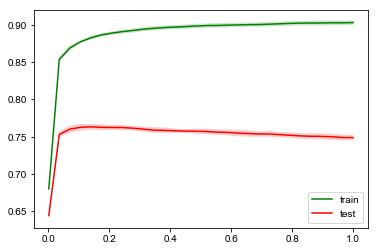

In [164]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

#### * Выбор параметров – длины сессии и ширины окна

Возьмем LinearSVC, показавший лучшее качество на кросс-валидации и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*).

Определим функцию model_assessment.

In [173]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, 
                     random_state=7, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    t_start = time()
    # Loading data
    with open(path_to_X_pickle, 'rb') as fid:
        X_sparse = pickle.load(fid)
    with open(path_to_y_pickle, 'rb') as fid:
        y = pickle.load(fid)
    #print(X_sparse.shape)
    # Spliting on train and validation
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                          test_size=test_size, 
                                                          random_state=random_state,
                                                          stratify=y)
    
    # Cross_validation extimation
    scores = cross_val_score(estimator, X_train, y_train, cv=cv, n_jobs=-1)
    # Model fitting
    estimator.fit(X_train, y_train)
    # Accuracy score on validation set
    acc_score = accuracy_score(y_valid, estimator.predict(X_valid))
    
    return scores.mean(), acc_score, time() - t_start

Применим функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, svm\_grid\_searcher2.best\_estimator\_) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведем в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 

In [174]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 'capstone_websites_data/X_sparse_10users.pkl',
                 'capstone_websites_data/y_10users.pkl', skf, random_state=7, test_size=0.3)

(0.76317044850074478, 0.78316582914572863, 2.0529651641845703)

In [176]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length and (window_size, session_length) != (10, 10):
        path_to_X_pkl = 'capstone_websites_data/X_sparse_10users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
        path_to_y_pkl = 'capstone_websites_data/y_10users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
        print("Session length: {}, Window size: {}".format(session_length, window_size))
        print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=7, test_size=0.3))

Session length: 15, Window size: 10
(0.82513418469054312, 0.83763925100734771, 3.3480961322784424)
Session length: 15, Window size: 7
(0.84452352050878676, 0.86892317902770866, 5.123607158660889)
Session length: 10, Window size: 7
(0.79523445922969482, 0.81864941098390576, 3.4673569202423096)
Session length: 7, Window size: 7
(0.74957553499595253, 0.7663846026215364, 2.2991409301757812)
Session length: 15, Window size: 5
(0.86546150322993787, 0.87980085348506398, 10.58650517463684)
Session length: 10, Window size: 5
(0.81841320290403219, 0.82515410146989099, 5.673277139663696)
Session length: 7, Window size: 5
(0.77507312972754183, 0.7804646752015173, 3.6008009910583496)
Session length: 5, Window size: 5
(0.72868540654952696, 0.7316263632053106, 3.0794379711151123)
CPU times: user 16 s, sys: 973 ms, total: 17 s
Wall time: 37.2 s


Сравним для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10).

In [177]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    if window_size <= session_length and (window_size, session_length):
        path_to_X_pkl = 'capstone_websites_data/X_sparse_150users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
        path_to_y_pkl = 'capstone_websites_data/y_150users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
        
        print("Session length: {}, Window size: {}".format(session_length, window_size))
        print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=7, test_size=0.3))

Session length: 5, Window size: 5
(0.40886120162069139, 0.42208108239645692, 376.5649781227112)
Session length: 7, Window size: 7
(0.4359972495897369, 0.45382702592226726, 386.4537510871887)
Session length: 10, Window size: 10
(0.46174147751856959, 0.48401693183476863, 344.979966878891)
CPU times: user 9min 17s, sys: 7.67 s, total: 9min 24s
Wall time: 18min 28s


#### * Идентификация конкретного пользователя и кривые обучения

Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 10 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.

In [178]:
with open('capstone_websites_data/X_sparse_150users.pkl', 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open('capstone_websites_data/y_150users.pkl', 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [179]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                                      random_state=7, stratify=y_150users)

Обучим LogisticRegressionCV для одного значения параметра C. Теперь решаем 150 задач "Один-против-Всех", поэтому аргумент multi_class='ovr'. Как всегда n_jobs=-1 и random_state=7.

In [180]:
C_opt = logit_grid_searcher2.Cs_[logit_mean_cv_scores2.argmax()]
C_opt2 = logit_grid_searcher2.Cs_[logit_mean_cv_scores2.argmax()]
C_opt

1.0

In [181]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[C_opt], cv=skf, random_state=7, n_jobs=-1, multi_class='ovr')
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 5min 44s, sys: 31.5 s, total: 6min 16s
Wall time: 7min 28s


Посмотрим на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.

In [182]:
cv_scores_by_user = logit_cv_150users.scores_
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, cv_scores_by_user[user_id].mean()))

User 1, CV score: 0.996100316562
User 2, CV score: 0.996465649458
User 3, CV score: 0.995214433137
User 4, CV score: 0.992159436432
User 5, CV score: 0.990188699739
User 6, CV score: 0.994411769248
User 7, CV score: 0.993650447827
User 8, CV score: 0.985831228894
User 9, CV score: 0.998029522399
User 10, CV score: 0.995057871644
User 11, CV score: 0.994536863482
User 12, CV score: 0.993452373891
User 13, CV score: 0.996882658137
User 14, CV score: 0.994922447987
User 15, CV score: 0.996402928
User 16, CV score: 0.996194472348
User 17, CV score: 0.990772843906
User 18, CV score: 0.994463652779
User 19, CV score: 0.994693085498
User 20, CV score: 0.99134658842
User 21, CV score: 0.980367673937
User 22, CV score: 0.996726261305
User 23, CV score: 0.99470340619
User 24, CV score: 0.990772915559
User 25, CV score: 0.996590772731
User 26, CV score: 0.994213495822
User 27, CV score: 0.995089074498
User 28, CV score: 0.991586275966
User 29, CV score: 0.98467344869
User 30, CV score: 0.99729963

Посчитаем для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью LogisticRegressionCV) и долей меток в *y_train_150*, отличных от ID этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).

In [195]:
class_distr = np.bincount(y_train_150.astype('int'))
np.bincount(y_train_150.astype('int')).shape

(151,)

In [196]:
class_distr[128]

309

In [197]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = []
for user_id in np.unique(y_train_150):
    val = (class_distr.sum() - class_distr[user_id])/class_distr.sum()
    print(val)
    acc_diff_vs_constant.append(cv_scores_by_user[user_id].mean() - val)
    print("User: {} difference: {}".format(user_id, cv_scores_by_user[user_id].mean() -\
                                           val))

0.984402531461
User: 1 difference: 0.0116977851016
0.995704440483
User: 2 difference: 0.000761208975235
0.994401176066
User: 3 difference: 0.000813257071489
0.984715314921
User: 4 difference: 0.00744412151073
0.987947410674
User: 5 difference: 0.00224128906498
0.994453306642
User: 6 difference: -4.15373943695e-05
0.992545327536
User: 7 difference: 0.00110512029063
0.98391250404
User: 8 difference: 0.00191872485383
0.997122392168
User: 9 difference: 0.000907130231454
0.993827739722
User: 10 difference: 0.00123013192177
0.994150949298
User: 11 difference: 0.000385914183726
0.992044874
User: 12 difference: 0.00140749989032
0.996924295977
User: 13 difference: -4.16378397855e-05
0.99485992514
User: 14 difference: 6.25228467465e-05
0.996350859633
User: 15 difference: 5.20683667128e-05
0.996194467903
User: 16 difference: 4.44444858694e-09
0.990074338202
User: 17 difference: 0.000698505704104
0.994150949298
User: 18 difference: 0.000312703481327
0.994745237872
User: 19 difference: -5.215237343

In [198]:
(np.array(acc_diff_vs_constant) > 0).sum()/len(acc_diff_vs_constant)

0.87333333333333329

### Соревнование Kaggle Inclass по идентификации пользователей

Считаем данные [соревнования](https://inclass.kaggle.com/c/identify-me-if-you-can-yandex-mipt/data) в DataFrame train_df и test_df (обучающая и тестовая выборки).

In [213]:
time_ = ['time1', 'time2', 'time3', 'time4', 'time5', 'time6', 'time7', 'time8', 'time9', 'time10']

train_df = pd.read_csv('/Users/yaroina-kente/Identification/kaggle_data/train_sessions.csv', parse_dates = time_, index_col='session_id')
test_df = pd.read_csv('/Users/yaroina-kente/Identification/kaggle_data/test_sessions.csv', parse_dates = time_, index_col='session_id')

In [214]:
train_test_df = pd.concat([train_df, test_df])

In [215]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null datetime64[ns]
site2     250098 non-null float64
time2     250098 non-null datetime64[ns]
site3     246919 non-null float64
time3     246919 non-null datetime64[ns]
site4     244321 non-null float64
time4     244321 non-null datetime64[ns]
site5     241829 non-null float64
time5     241829 non-null datetime64[ns]
site6     239495 non-null float64
time6     239495 non-null datetime64[ns]
site7     237297 non-null float64
time7     237297 non-null datetime64[ns]
site8     235224 non-null float64
time8     235224 non-null datetime64[ns]
site9     233084 non-null float64
time9     233084 non-null datetime64[ns]
site10    231052 non-null float64
time10    231052 non-null datetime64[ns]
target    253561 non-null int64
dtypes: datetime64[ns](10), float64(9), int64(2)
memory usage: 42.6 MB


В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно. Индексы нумеровались с 1, так что заменим пропуски на нули.

In [216]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

Добавим новые признаки:
* день недели начала сессии
* час начала сессии
* число уникальных сайтов в сессии
* продолжительность нахождения на сайте для каждого этапа сессии.

In [217]:
def New_features(data):
    
    time_cols = ['time%d' % i for i in range(1, 11)]
    site_cols = ['site%d' % i for i in range(1, 11)]
    time_diff = []
    unique_sites = []
    start_hour = []
    day_of_week = []
    
    sites = data[site_cols].values.tolist()
    
    for i, (l, time) in tqdm_notebook(enumerate(data[time_cols].iterrows())):
        time_diff.append([0] * (9))
        
        for n in range(9):
            if not pd.isnull(time[n]) and not pd.isnull(time[n+1]):
                time_diff[i][n] = int((time[n+1]-time[n])/np.timedelta64(1, 's'))
        
        start_hour.append(time[0].hour)
        day_of_week.append(time[0].dayofweek)
        
        unique = set(sites[i])
        try:
            unique_sites.remove(0) # remove site '0' from session
        except: 
            pass
        
        unique_sites.append(len(unique))
    
    
    time_diff = np.array(time_diff, dtype='int')                         # продолжительность нахождения на сайте
    unique_sites = np.array(unique_sites).reshape(time_diff.shape[0],1)  # число уникальных сайтов в сессии
    start_hour = np.array(start_hour).reshape(time_diff.shape[0],1)      # час начала сессии
    day_of_week = np.array(day_of_week).reshape(time_diff.shape[0],1)    # день недели начала сессии
    
    data_ = np.hstack((time_diff, unique_sites, start_hour, day_of_week))
    
    columns = ['time_diff' + str(j) for j in range(1,10)] + ['#unique_sites', 'start_hour', 'day_of_week']
    
    data_frame = pd.DataFrame(data_, columns=columns, index=data.index)
    return data_frame

In [218]:
%%time
data_new_features = New_features(train_test_df)

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


CPU times: user 29min 33s, sys: 1min 48s, total: 31min 21s
Wall time: 30min 49s


In [219]:
with open('/Users/yaroina-kente/Identification/kaggle_data/New_features.pkl', 'wb') as pkl:
    pickle.dump(data_new_features, pkl, protocol=2)

Сделаем разреженные матрицы *X_train_sparse* и *X_test_sparse* аналогично тому, как мы это делали ранее. Используем объединенную матрицу train_test_df_sites – потом разделим обратно на обучающую и тестовую части.

In [233]:
def CSR_Matrix(sessions):
    
    indices = list(np.array(sessions).reshape((1,sessions.size))[0])
    data = list(np.ones(sessions.size, dtype=int))
    indptr = [sessions.shape[1]*k for k in range(len(sessions)+1)]

    return csr_matrix((data, indices, indptr), dtype=int)[:,1:]

In [234]:
train_test_sparse = CSR_Matrix(train_test_df_sites.values)
print('Размер разреженной матрицы: {}'.format(train_test_sparse.get_shape()))

Размер разреженной матрицы: (336358, 48371)


Закодируем наши признаки прямым кодирование (одно горячее состояние), нормализуем их и объединим с исходными разреженными матрицами.

In [236]:
data_variables = pd.get_dummies(data_new_features, columns=['#unique_sites', 'start_hour', 'day_of_week'],
                                        sparse=True, drop_first=True)

In [238]:
matrix_feature = data_variables.values
matrix_feature.shape

(336358, 40)

In [240]:
scaler = StandardScaler()
features_scal = scaler.fit_transform(matrix_feature)

In [244]:
_sparse_ = sparse.hstack([train_test_sparse, features_scal]).tocsr()

In [245]:
X_train_sparse = _sparse_[:train_df.shape[0]]
X_test_sparse = _sparse_[train_df.shape[0]:]
y = train_df['target']

Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.

In [246]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

Создадим объект sklearn.linear_model.SGDClassifier с логистической функцией потерь и параметром random_state=17, n_jobs=-1. Обучим модель на выборке (X_train, y_train).

In [247]:
sgd_logit = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
sgd_logit.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=17, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [248]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)

In [249]:
roc_auc_sgd_logit = roc_auc_score(y_valid, logit_valid_pred_proba[:, 1])
print('ROC AUC score: {:.3f}'.format(roc_auc_sgd_logit))

ROC AUC score: 0.975


Сделаем прогноз в виде предсказанных вероятностей отнесения к классу 1 для тестовой выборки с помощью той же *sgd_logit*, обученной уже на всей обучающей выборке (а не на 70%).

In [250]:
time
sgd_logit.fit(X_train_sparse, y)
logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)

Полученный результат соответствует бейзлайну "SGDCLassifer" на лидерборде, 0.94753.

In [251]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [253]:
write_to_submission_file(logit_test_pred_proba[:, 1], '/Users/yaroina-kente/Identification/kaggle_data/res_1_sgd_logit.csv')

Посмотрим на параметры классификатора и подберём оптимальные.

In [254]:
%%time
sgd_logit = SGDClassifier(random_state=0, n_jobs=-1, loss='log')

params = {'alpha': np.linspace(1e-08,1e-03, 30),
          'penalty': ['l1','l2']}
grid_2 = GridSearchCV(sgd_logit, params, cv=5, scoring='roc_auc')
grid_2.fit(X_train_sparse, y)

CPU times: user 5min 7s, sys: 56.8 s, total: 6min 4s
Wall time: 5min 53s


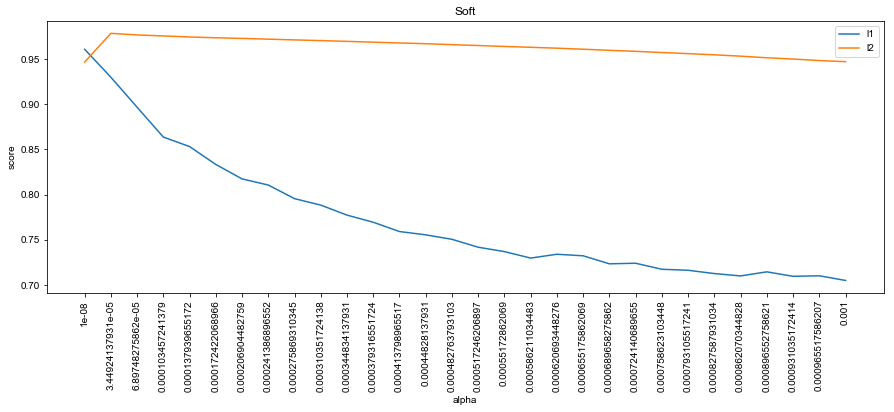

In [255]:
score_l1 = list(pd.Series(grid_2.cv_results_).mean_test_score[::2])
score_l2 = list(pd.Series(grid_2.cv_results_).mean_test_score[1::2])
param = list(pd.Series(grid_2.cv_results_).param_alpha[::2])

plt.figure(figsize=(15,5))
plt.title('Soft')
plt.plot(range(len(score_l1)), score_l1, label='l1')
plt.plot(range(len(score_l2)), score_l2, label='l2')
plt.xticks(range(len(score_l1)), param, rotation='vertical')
plt.xlabel('alpha')
plt.ylabel('score')
plt.legend()
plt.show()

In [257]:
grid_2.best_score_

0.97823396691328068

Полученный результат несколько лучше - 0.95383.

In [258]:
logit_test_pred_proba = grid_2.best_estimator_.predict_proba(X_test_sparse)[:,1]

In [260]:
write_to_submission_file(logit_test_pred_proba, '/Users/yaroina-kente/Identification/kaggle_data/res_3_sgd_logit.csv')

### Vowpal Wabbit. Tutorial

In [261]:
!vw --help

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1

VW options:
  --ring_size arg                       size of example ring
  --onethread                           Disable parse thread

Update options:
  -l [ --learning_rate ] arg            Set learning rate
  --power_t arg                         t power value
  --decay_learning_rate arg             Set Decay factor for learning_rate 
                                        between passes
  --initial_t arg                       initial t value
  --feature_mask arg                    Use existing regressor to determine 
                                        which parameters may be updated.  If no
                                        initial_regressor given, also used for 
                                        initial weights.

Weight options:
  -i [ --initial_regressor ] arg        Initial regressor(s)
  --initial_weight arg                  Set all weights t

                                        log_2 (#classes)
  --node_only arg (=0)                  only use node features, not full path 
                                        features
  --randomized_routing arg (=0)         randomized routing

Logarithmic Time Multiclass Tree:
  --log_multi arg                       Use online tree for multiclass

  --no_progress                         disable progressive validation
  --swap_resistance arg (=4)            higher = more resistance to swap, 
                                        default=4

Error Correcting Tournament Options:
  --ect arg                             Error correcting tournament with <k> 
                                        labels

  --error arg (=0)                      errors allowed by ECT

Boosting:
  --boosting arg                        Online boosting with <N> weak learners

  --gamma arg (=0.100000001)            weak learner's edge (=0.1), used only 
                                        by online BBM
  -

In [267]:
import vowpalwabbit as vw

Vowpal Wabbit любит, чтоб метки классов были распределены от 1 до K, где K – число классов в задаче классификации (в нашем случае – 550). Поэтому применим LabelEncoder, да еще и +1 добавим (LabelEncoder переводит метки в диапозон от 0 до K-1).

In [268]:
class_encoder = LabelEncoder().fit(y.astype('str'))
y_for_vw = class_encoder.transform(y.astype('str')) + 1

In [269]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y_for_vw, test_size=0.3, 
                                                     random_state=7, stratify=y_for_vw)

Реализуем функцию, переводящую разреженную матрицу в формат Vowpal Wabbit.

In [271]:
def sparse_matrix_to_vw(X_sparse, y=None, out_file='tmp.vw'):
    with open(out_file, 'w') as fid:
        for ind in range(X_sparse.shape[0]):
            # getting row and data from it
            row = X_sparse.getrow(ind)
            data = row.data
            indices = row.indices
            # extracting features
            val_dict = {}
            for index, value in zip(indices, data):
                if index not in val_dict:
                    val_dict[index] = value
                else:
                    val_dict[index] += value
            if y is not None:
                string = [str(y[ind]), "|"]
            else:
                string = [str(1), "|"]
            for site, count in val_dict.iteritems():
                string.append(str(site+1) + ":" + str(count))
            line = " ".join(string)
            fid.write(line+"\n")
        print ("Passed: %d lines" % (ind+1))

Применим написанную функцию к части обучающей выборки (X_train, y_train), к отложенной выборке (X_valid, y_valid), ко всей обучающей выборке (X_train_sparse, y_for_vw) и ко всей тестовой выборке X_test_sparse.

In [273]:
%%time
sparse_matrix_to_vw(X_train, y_train, '/Users/yaroina-kente/Identification/kaggle_data/train_part.vw')
sparse_matrix_to_vw(X_valid, y_valid, '/Users/yaroina-kente/Identification/kaggle_data/valid.vw')
sparse_matrix_to_vw(X_train_sparse, y_for_vw, '/Users/yaroina-kente/Identification/kaggle_data/train.vw')
sparse_matrix_to_vw(X_test_sparse, out_file='/Users/yaroina-kente/Identification/kaggle_data/test.vw')

Passed: 177492 lines
Passed: 76069 lines
Passed: 253561 lines
Passed: 82797 lines
CPU times: user 6min 13s, sys: 5.59 s, total: 6min 18s
Wall time: 6min 21s


Обучим модель на выборке kaggle_data/train_part.vw.

In [274]:
%%time
!vw --oaa 550 kaggle_data/train_part.vw --passes 10 --cache_file kaggle_data/cache -k -b 26 --loss_function hinge \
-f kaggle_data/model.vw --quiet

CPU times: user 2.6 s, sys: 4.17 s, total: 6.77 s
Wall time: 2min


In [275]:
%%time
!vw -i kaggle_data/model.vw -t -d kaggle_data/valid.vw --random_seed 7 -p kaggle_data/vw_valid_pred.csv --quiet

CPU times: user 119 ms, sys: 206 ms, total: 325 ms
Wall time: 4.88 s


In [276]:
vw_valid_pred = pd.read_csv("kaggle_data/vw_valid_pred.csv", header=None)
accuracy_score(y_valid, vw_valid_pred)

0.99267770050874859

Обучим модель с теми же параметрами на всей обучающей выборке – kaggle_data/train.vw. При этом используем новый кэш-файл (--cache_file).

In [277]:
%%time
!vw --oaa 550 kaggle_data/train.vw --passes 10 --cache_file kaggle_data/cache_all -k -b 26 \
--loss_function hinge -f kaggle_data/model.vw --quiet

CPU times: user 3.55 s, sys: 5.52 s, total: 9.08 s
Wall time: 2min 42s


In [278]:
%%time
!vw -i kaggle_data/model.vw -t -d kaggle_data/test.vw --random_seed 7 -p kaggle_data/vw_test_pred.csv

only testing
predictions = kaggle_data/vw_test_pred.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = kaggle_data/test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0        1        1       51
0.000000 0.000000            2            2.0        1        1       42
0.000000 0.000000            4            4.0        1        1       48
0.000000 0.000000            8            8.0        1        1       44
0.000000 0.000000           16           16.0        1        1       46
0.000000 0.000000           32           32.0        1        1       44
0.000000 0.000000           64           64.0        1        1       44
0.000000 0.000000          128          128.0        1        1       43
0.000000 0.000000          256          256.0        1        1       48
0.

Запишем прогноз в файл, применим обратное преобразование меток (был LabelEncoder и потом +1 в меткам) и отправим решение на Kaggle.

In [290]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [291]:
vw_pred = pd.read_csv("kaggle_data/vw_test_pred.csv", header=None)

In [292]:
vw_subm = class_encoder.inverse_transform(vw_pred - 1)

In [293]:
write_to_submission_file(vw_subm,
                         'kaggle_data/first_vw_submission.csv')

## Итоги

В данном проекте было предложено решить задачу идентификации одного конкретного пользователя из множества других посредством обработки информации о его сессиях в интернете.

Первоначально были предоставлены данные о сессиях пользователей, среди которых был выделен один - "Элис", его и необходимо было научиться идентифицировать. Задача свелась к классической задаче бинарной классификации с сильным дисбалансом классов.
Baseline-решения уже на начальных данных после tf-idf преобразования показали неплохие результаты на AUC-ROC. После генерации дополнительных признаков, их отбора и подбора параметров поиском по сетке результат на public leaderboarde вошёл в топ-10%.

Знакомство с библиотекой Vowpal Wabbit можно отнести к специфическим. У неё огромный потенциал и жутко неудобный (примечание: субъективное мнение автора) интерфейс. С другой стороны, хорошо знать об инструментах, которые могут потом пригодиться.

Полученная модель может быть использована для распознавания конкретного пользователя по его сессиям в интернете.

<img src="image.png">